# Journey to Springfield
### Сунгатуллин Руслан

Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import copy
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output

from PIL import Image
from pathlib import Path
from skimage.transform import resize
from skimage import color, io

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from tqdm import tqdm, tqdm_notebook
from torch.utils.data import Dataset, DataLoader

In [2]:
batch_size = 64
img_size = 224
device = torch.device(0)
torch.cuda.set_device(device)

In [3]:
SEED = 123

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Загрузка данных

In [4]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = files
        self.mode = mode
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump:
            pickle.dump(self.label_encoder, le_dump)

    def __len__(self):
        return len(self.files)

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        
  
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((img_size, img_size))
        return np.array(image)

In [5]:
TRAIN_DIR = Path('/kaggle/input/simpsons4/train')
TEST_DIR = Path('/kaggle/input/simpsons4/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [6]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [7]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
def imshow(img, title=None, plt_ax=plt, default=False):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt_ax.imshow(img)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

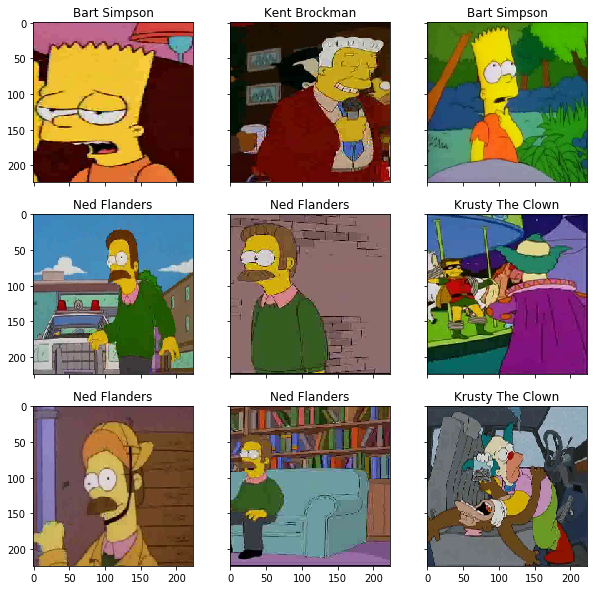

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Training

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 42)

model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s] 


In [12]:
dataloaders = {'train':train_dataloader, 
              'val': val_dataloader}
dataset_sizes = {'train': len(train_files), 'val':len(val_files)}

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.8106 Acc: 0.5959
val Loss: 0.8443 Acc: 0.8259

Epoch 1/9
----------
train Loss: 0.6240 Acc: 0.8688
val Loss: 0.5041 Acc: 0.8901

Epoch 2/9
----------
train Loss: 0.3806 Acc: 0.9185
val Loss: 0.3865 Acc: 0.9121

Epoch 3/9
----------
train Loss: 0.2632 Acc: 0.9429
val Loss: 0.3156 Acc: 0.9266

Epoch 4/9
----------
train Loss: 0.1876 Acc: 0.9626
val Loss: 0.2733 Acc: 0.9350

Epoch 5/9
----------
train Loss: 0.1403 Acc: 0.9749
val Loss: 0.2467 Acc: 0.9454

Epoch 6/9
----------
train Loss: 0.1051 Acc: 0.9829
val Loss: 0.2318 Acc: 0.9467

Epoch 7/9
----------
train Loss: 0.0834 Acc: 0.9894
val Loss: 0.2275 Acc: 0.9496

Epoch 8/9
----------
train Loss: 0.0805 Acc: 0.9892
val Loss: 0.2252 Acc: 0.9496

Epoch 9/9
----------
train Loss: 0.0782 Acc: 0.9899
val Loss: 0.2234 Acc: 0.9507

Training complete in 21m 23s
Best val Acc: 0.950707


## Predicting

In [13]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [14]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_ft, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [15]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [16]:
submit.to_csv('submission.csv', index=False)